In [1]:
conda install -c conda-forge tensorflow 

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [ ]:
conda install -c numba numba

In [ ]:
conda install -c conda-forge librosa

In [ ]:
conda install -c conda-forge keras

In [ ]:
conda install -c conda-forge pydot

In [ ]:
conda install -c conda-forge pydub

In [1]:
import tensorflow as tf
import numpy as np
import scipy
from scipy import misc
import glob
from PIL import Image
import os
import matplotlib.pyplot as plt
import librosa
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from keras.initializers import glorot_uniform
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from pydub import AudioSegment
import shutil
from keras.preprocessing.image import ImageDataGenerator
import random
from sklearn.metrics import confusion_matrix

In [2]:
genres = ['blues', 'classical', 'country', 'disco', 'pop', 'hiphop', 'metal', 'reggae', 'rock']

In [4]:
for g in genres:
  path1 = os.path.join('D:/CNN/5sec',f'{g}')
  os.makedirs(path1)
  path = os.path.join('D:/CNN/spectrogram5sec',f'{g}')
  
  os. makedirs(path)

In [ ]:
from pydub import AudioSegment
for g in genres:
  j=0
  print(f"{g}")
  for filename in os.listdir(os.path.join('D:/CNN/Data/genres_original',f"{g}")):

    song  =  os.path.join(f'D:/CNN/Data/genres_original/{g}',f'{filename}')
    j = j+1
    for w in range(0,6):
      t1 = 5*(w)*1000
      t2 = 5*(w+1)*1000
      newAudio = AudioSegment.from_wav(song)
      new = newAudio[t1:t2]
      new.export(f'D:/CNN/5sec/{g}/{g+str(j)+str(w)}.wav', format="wav")

In [ ]:
for g in genres:
  j = 0
  print(g)
  for filename in os.listdir(os.path.join('D:/CNN/5sec',f"{g}")):
    song  =  os.path.join(f'D:/CNN/5sec/{g}',f'{filename}')
    j = j+1
    plt.rcParams["figure.autolayout"] = True
    plt.rcParams["figure.figsize"] = [4.32, 2.88]
    y,sr = librosa.load(song,duration=5)
    mels = librosa.feature.melspectrogram(y=y,sr=sr)
    fig = plt.Figure()
    canvas = FigureCanvas(fig)
    p = plt.imshow(librosa.power_to_db(mels,ref=np.max))
    plt.savefig(f'D:/CNN/spectrogram5sec/{g}/{g+str(j)}.png')

In [4]:
directory = "D:/CNN/spectrogram5sec/"
for g in genres:
  filenames = os.listdir(os.path.join(directory,f"{g}"))
  random.shuffle(filenames)
  test_files = filenames[0:100]

  for f in test_files:

    shutil.move(directory + f"{g}"+ "/" + f,"D:/CNN/test5sec/" + f"{g}")

In [3]:
train_dir = "D:/CNN/spectrogram5sec/"
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir,target_size=(288,432),color_mode="rgb",class_mode='categorical',batch_size=128)

validation_dir = "D:/CNN/test5sec/"
vali_datagen = ImageDataGenerator(rescale=1./255)
vali_generator = vali_datagen.flow_from_directory(validation_dir,target_size=(288,432),color_mode='rgb',class_mode='categorical',batch_size=128)

Found 4500 images belonging to 9 classes.
Found 900 images belonging to 9 classes.


In [4]:
def GenreModel(input_shape = (288,432,3),classes=9):
  np.random.seed(9)
  X_input = Input(input_shape)

  X = Conv2D(8,kernel_size=(3,3),strides=(1,1),kernel_initializer = glorot_uniform(seed=9))(X_input)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)
  
  X = Conv2D(16,kernel_size=(3,3),strides = (1,1),kernel_initializer=glorot_uniform(seed=9))(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)
  
  X = Conv2D(32,kernel_size=(3,3),strides = (1,1),kernel_initializer = glorot_uniform(seed=9))(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)

  X = Conv2D(64,kernel_size=(3,3),strides=(1,1),kernel_initializer=glorot_uniform(seed=9))(X)
  X = BatchNormalization(axis=-1)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)

  
  X = Flatten()(X)

  X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=9))(X)

  model = Model(inputs=X_input,outputs=X,name='GenreModel')

  return model

In [5]:
import keras.backend as K
def get_f1(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [6]:
model = GenreModel(input_shape=(288,432,3),classes=9)
opt = Adam(learning_rate=0.00005)
model.compile(optimizer = opt,loss='categorical_crossentropy',metrics=['accuracy',get_f1])

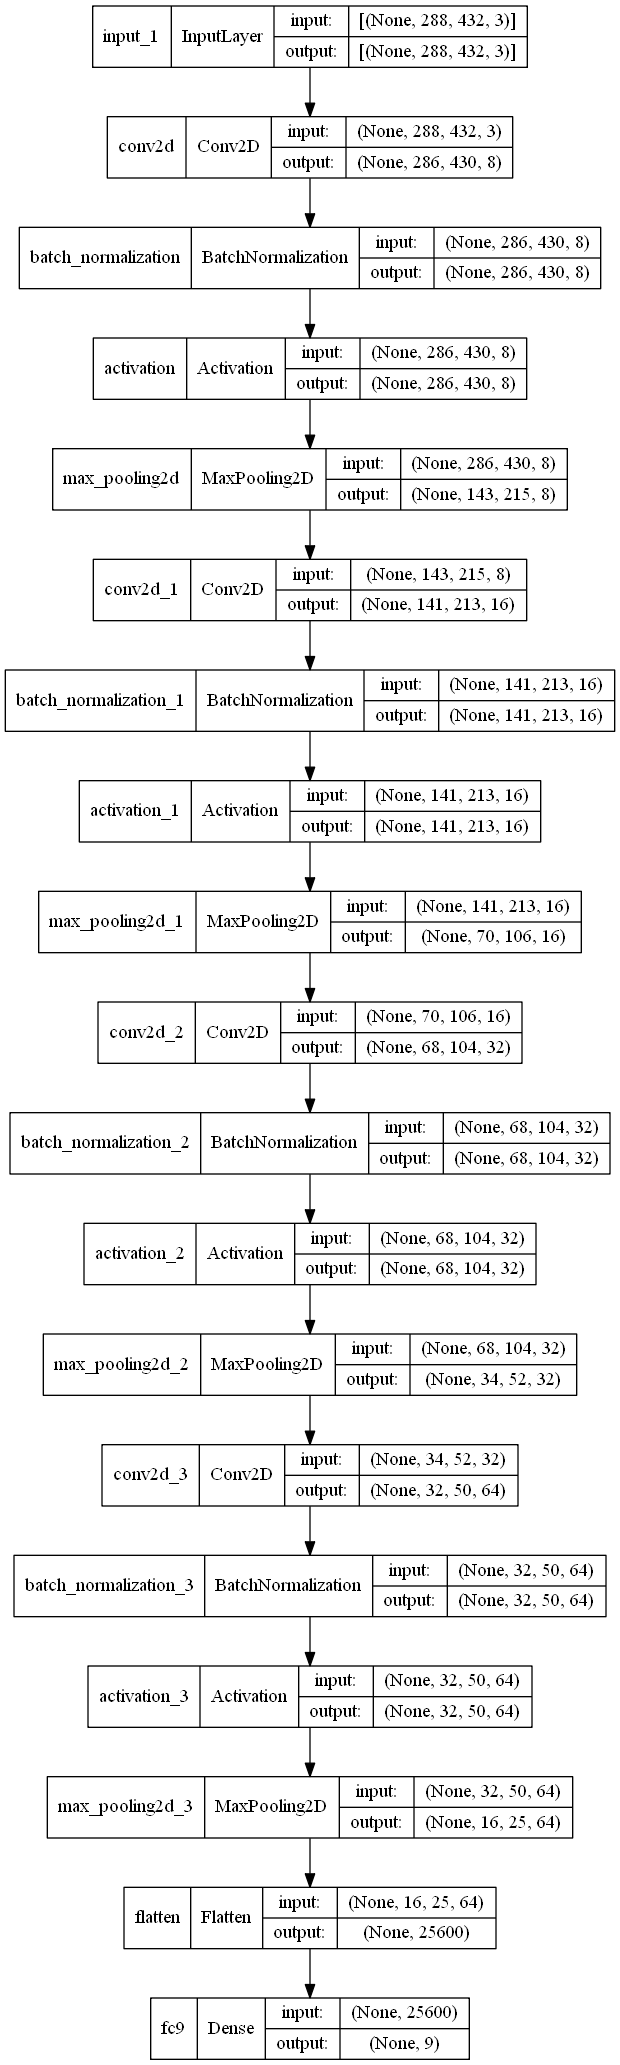

In [10]:
plot_model(model,to_file='CNN_model.png',show_shapes=True)


In [11]:
model.fit(train_generator,epochs=40,validation_data=vali_generator)

Epoch 1/40
36/36 [==============================] - 268s 7s/step - loss: 2.0055 - accuracy: 0.2607 - get_f1: 0.0414 - val_loss: 2.1973 - val_accuracy: 0.1111 - val_get_f1: 0.0000e+00
Epoch 2/40
36/36 [==============================] - 249s 7s/step - loss: 1.5396 - accuracy: 0.4436 - get_f1: 0.2241 - val_loss: 2.2090 - val_accuracy: 0.1111 - val_get_f1: 0.0000e+00
Epoch 3/40
36/36 [==============================] - 251s 7s/step - loss: 1.3333 - accuracy: 0.5158 - get_f1: 0.3696 - val_loss: 2.2670 - val_accuracy: 0.1111 - val_get_f1: 0.0000e+00
Epoch 4/40
36/36 [==============================] - 251s 7s/step - loss: 1.1894 - accuracy: 0.5782 - get_f1: 0.4631 - val_loss: 2.3569 - val_accuracy: 0.1111 - val_get_f1: 0.0000e+00
Epoch 5/40
36/36 [==============================] - 250s 7s/step - loss: 1.0741 - accuracy: 0.6213 - get_f1: 0.5388 - val_loss: 2.4786 - val_accuracy: 0.1111 - val_get_f1: 0.0000e+00
Epoch 6/40
36/36 [==============================] - 252s 7s/step - loss: 0.9936 - acc

In [13]:
model.fit(train_generator,epochs=10,validation_data=vali_generator)


Epoch 1/10
36/36 [==============================] - 258s 7s/step - loss: 0.1336 - accuracy: 0.9898 - get_f1: 0.9871 - val_loss: 0.6511 - val_accuracy: 0.7733 - val_get_f1: 0.7473
Epoch 2/10
36/36 [==============================] - 255s 7s/step - loss: 0.1262 - accuracy: 0.9922 - get_f1: 0.9906 - val_loss: 0.6355 - val_accuracy: 0.7822 - val_get_f1: 0.7968
Epoch 3/10
36/36 [==============================] - 254s 7s/step - loss: 0.1234 - accuracy: 0.9933 - get_f1: 0.9894 - val_loss: 0.6529 - val_accuracy: 0.7700 - val_get_f1: 0.8027
Epoch 4/10
36/36 [==============================] - 257s 7s/step - loss: 0.1156 - accuracy: 0.9960 - get_f1: 0.9910 - val_loss: 0.6335 - val_accuracy: 0.7867 - val_get_f1: 0.7771
Epoch 5/10
36/36 [==============================] - 257s 7s/step - loss: 0.1084 - accuracy: 0.9953 - get_f1: 0.9937 - val_loss: 0.6199 - val_accuracy: 0.7889 - val_get_f1: 0.7811
Epoch 6/10
36/36 [==============================] - 262s 7s/step - loss: 0.1023 - accuracy: 0.9964 - get_

In [15]:
model.fit(train_generator,epochs=1,validation_data=vali_generator)

36/36 [==============================] - 260s 7s/step - loss: 0.0811 - accuracy: 0.9987 - get_f1: 0.9972 - val_loss: 0.6143 - val_accuracy: 0.7944 - val_get_f1: 0.8185


In [16]:
model.save('Music_CNN.h5')

In [20]:
model = GenreModel(input_shape=(288,432,3),classes=9)
opt = Adam(learning_rate=0.00005)
model.compile(optimizer = opt,loss='categorical_crossentropy',metrics=['accuracy',get_f1])

In [15]:
model = GenreModel(input_shape=(288,432,3),classes=9)
model.load_weights('D:/CNN/app/Music_CNN.h5')

In [13]:
img = image.load_img('D:/CNN/test5sec/reggae/reggae1.png', target_size=(288,432,3))
ts = image.img_to_array(img)

ts = np.reshape(ts,(1,288,432,3))
prediction = model.predict(ts/255)

prediction = prediction.reshape((9,)) 

class_label = np.argmax(prediction)
print(f'{class_label}: {prediction*100}')

7: [11.232061  11.898692   9.367132  11.293999  11.086574   9.131357
 11.064712  13.8767805 11.048691 ]


In [ ]:
sound = AudioSegment.from_mp3('D:/CNN/Taylor Swift - Blank Space.mp3')
sound.export("music_file.wav",format="wav")

In [ ]:
wav = AudioSegment.from_wav('music_file.wav')
wav = wav[30000:35000]
wav.export("extracted.wav",format='wav')

In [ ]:
y,sr = librosa.load("extracted.wav",duration=5)
mels = librosa.feature.melspectrogram(y=y,sr=sr)

fig = plt.Figure()
canvas = FigureCanvas(fig)
p = plt.imshow(librosa.power_to_db(mels,ref=np.max))
plt.savefig('melspectrogram.png')

In [14]:
img = image.load_img('melspectrogram.png', target_size=(288,432,3))
ts = image.img_to_array(img)

ts = np.reshape(ts,(1,288,432,3))
prediction = model.predict(ts/255)

prediction = prediction.reshape((9,)) 

class_label = np.argmax(prediction)
print(f"{class_label}: {prediction}")

7: [0.10880634 0.11907727 0.09890965 0.1103431  0.11103313 0.0892657
 0.11058358 0.14082894 0.11115234]
